# Zero dimensional li-s model

In this notebook we solve the model given in Marinescu et al, 2016. 

In [1]:
%pip install pybamm -q

import pybamm
import numpy as np 
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


We first load the model and update the parameter values to match those given in the paper

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016()

# Update current and ICs to correspond to initial 2.4V as in ref [2]
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": 1.7,
        "Initial Condition for S8 ion [g]": 2.6730,
        "Initial Condition for S4 ion [g]": 0.0128,
        "Initial Condition for S2 ion [g]": 4.3321e-6,
        "Initial Condition for S ion [g]": 1.6321e-6,
        "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
        "Initial Condition for Terminal Voltage [V]": 2.4,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
    }
)

We then set up and solve the simulation. There will be some warning where the solver steps into an infeasible region (e.g. where concentration goes negative). These can safely be ignored as the failed steps will be rejected by the solver. 

In [3]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, max_step_decrease_count=10, 
    ),
)
sim.solve(np.linspace(0, 7000, 700))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [4]:
sim.plot(model.variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.8621237349643667, step=0.01862123734964366…

In [5]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  1.050 s
Final time:  6703.64544587172 s
Termination reason:  event: Zero theoretical capacity


We see that the solver stopped when zero theoretical capacity.

Now we can extract the variables we are interested in from the solution object and plot the results. Let's define a custom plotting function

In [6]:
def my_plot(sim):
    # extract variables 
    t = sim.solution["Time [s]"].entries
    S8 = sim.solution["S8 [g]"].entries
    S4 = sim.solution["S4 [g]"].entries
    S2 = sim.solution["S2 [g]"].entries
    Sp = sim.solution["Precipitated Sulfur [g]"].entries
    S_tot = S8 + S4 + S2 + Sp
    i_H = sim.solution["High plateau current [A]"].entries
    i_L = sim.solution["Low plateau current [A]"].entries
    eta_H = sim.solution["High plateau over-potential [V]"].entries
    eta_L = sim.solution["Low plateau over-potential [V]"].entries
    E_H = sim.solution["High plateau potential [V]"].entries
    E_L = sim.solution["Low plateau potential [V]"].entries
    V = sim.solution["Terminal voltage [V]"].entries

    # set up figure and plot
    fig, ax = plt.subplots(2, 2, figsize=(15,8))

    ax[0, 0].plot(t, S8, label="S8")
    ax[0, 0].plot(t, S4, label="S4")
    ax[0, 0].plot(t, S2, label="S2")
    ax[0, 0].plot(t, Sp, label="Sp")
    ax[0, 0].plot(t, S_tot, label="S_{tot}")
    ax[0, 0].set_xlim([0, 8000])
    ax[0, 0].set_ylim([0, 3])
    ax[0, 0].set_xlabel("Time [s]")
    ax[0, 0].set_ylabel("Species mass [g]")
    ax[0, 0].legend()

    ax[0, 1].plot(t, i_H, label="i_H")
    ax[0, 1].plot(t, i_L, label="i_L")
    ax[0, 1].set_xlim([0, 8000])
    ax[0, 1].set_ylim([0, 2])
    ax[0, 1].set_xlabel("Time [s]")
    ax[0, 1].set_ylabel("Reaction current [A]")
    ax[0, 1].legend()

    ax[1, 0].plot(t, eta_H, label="eta_H")
    ax[1, 0].plot(t, eta_L, label="eta_L")
    ax[1, 0].set_xlim([0, 8000])
    ax[1, 0].set_ylim([-20e-3, 0])
    ax[1, 0].set_xlabel("Time [s]")
    ax[1, 0].set_ylabel("Reaction overpotential [V]")
    ax[1, 0].legend()

    ax[1, 1].plot(t, E_H, label="E_H")
    ax[1, 1].plot(t, E_L, label="E_L")
    ax[1, 1].plot(t, V, label="V")
    ax[1, 1].set_xlim([0, 8000])
    ax[1, 1].set_ylim([2.2, 2.45])
    ax[1, 1].set_xlabel("Time [s]")
    ax[1, 1].set_ylabel("Nernst and cell voltages [V]")
    ax[1, 1].legend()

and create the plot

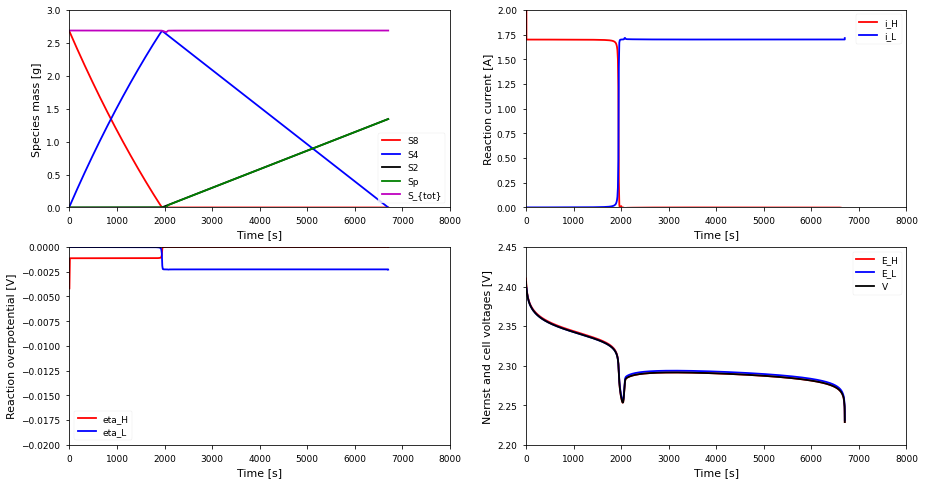

In [7]:
my_plot(sim)

## Speeding up the solve time

We see that the solution ended because we hit an "event". We can speed up the solve time by using the `CasadiSolver` in "fast" mode, but this doesn't support events. Instead we can solve up to a time just before the event was hit, and see that the solve time is reduced.

In [8]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast",
    ),
)
sim.solve(np.linspace(0, 6680, 680))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [9]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  13.619 ms
Final time:  6680.0 s
Termination reason:  final time


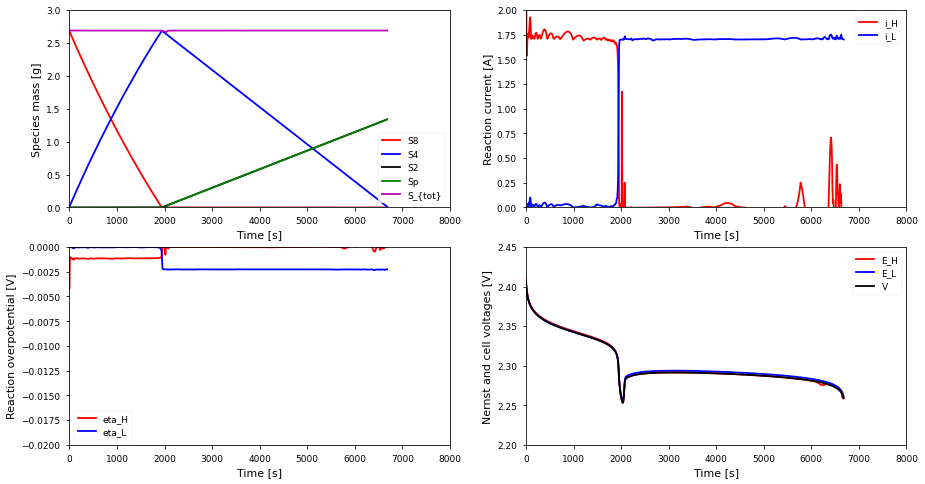

In [10]:
my_plot(sim)

Now we get some oscillations in the solution - why? Let's try smoothing the step functions (less than / greater than)

In [11]:
pybamm.settings.set_smoothing_parameters(10)
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast",
    ),
)
sim.solve(np.linspace(0, 6680, 680))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [12]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  12.796 ms
Final time:  6680.0 s
Termination reason:  final time


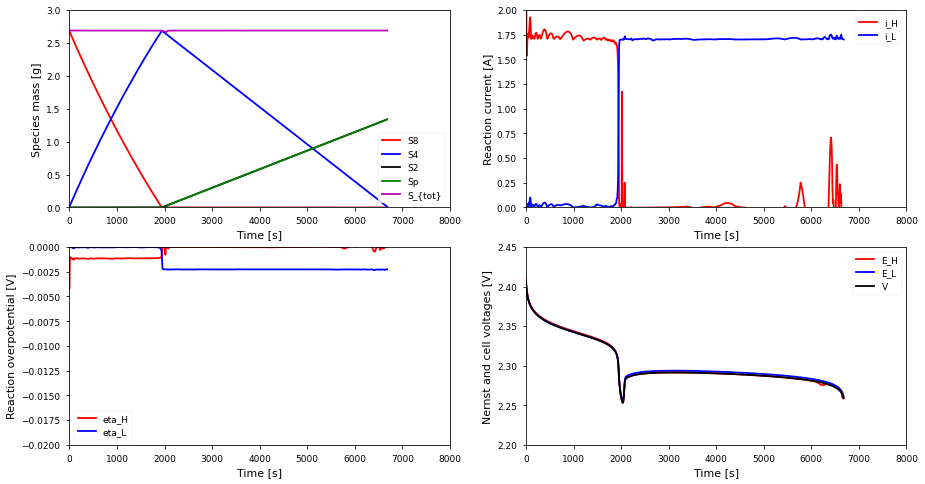

In [13]:
my_plot(sim)

That didn't help, let's tighten the tolerances

In [14]:
pybamm.settings.set_smoothing_parameters("exact")  # return smoothing settings to "exact"
 
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-8, rtol=1e-8, mode="fast",
    ),
)
sim.solve(np.linspace(0, 6680, 680))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 6658.1 and h = 5.55258e-08, the corrector convergence failed repeatedly or with |h| = hmin.


SolverError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.

This now fails. Let's reduce the maximum step size instead

In [15]:
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1},
    ),
)
sim.solve(np.linspace(0, 6680, 680))

In [16]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  457.592 ms
Final time:  6680.0 s
Termination reason:  final time


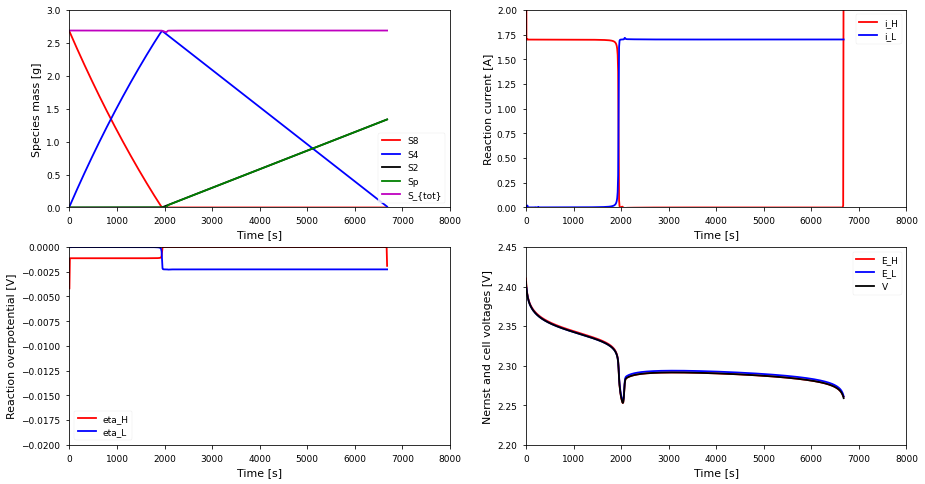

In [17]:
my_plot(sim)

This looks better. I think the solver is really struggling with the step change in the shuttle coefficient. "Safe" mode probably performs better (in terms of not giving oscillations) as it is "restarted" throughout the solve and is likely dealing with the step by effectively solving up to it, then restarting the solve with the new shuttle coefficient and "glueing" the solution together. 

## Speeding up safe mode

You can speed up "safe" model by increasing `dt_max`. Generally, increasing `dt_max` leads to a shorter solve time, but make it too big and the solver will fail. Basically, "safe" mode tries to solve the problem in chunks of size `dt_max` and stick the solutions together. Using bigger chunks means you spend less time setting up the integrator, but if the chunk is too big you can spend a long time failing. For example, say your model will hit zero concentration at 200s and you set `dt_max` to 1000s - the solver tries to solve up to 1000s but fails, then halves the interval to 500s, fails again, etc. On the other hand, if you set `dt_max` to 10s you spend a lot of time stopping and starting before you get to the event. You can see how there is some guesswork here and obviously in practice you don't know when you expect the simulation to stop, but if you can use your intuition/knowledge of the problem to guess as good `dt_max` then it can really help speed things up. 

Looking at the solution, the "hard" part of the problem occurs around 2000s, so a `dt_max` on the order of thousands of seconds (but less than 2000s!!) will probably give good results. I tried 1000s, but that failed.Picking 100s seems to give good results. 

In [39]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, max_step_decrease_count=10, dt_max=100, 
        extra_options_setup={"max_step_size": 0.1},
    ),
)
sim.solve(np.linspace(0, 7000, 700))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [40]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  663.272 ms
Final time:  6703.023342167464 s
Termination reason:  event: Zero theoretical capacity


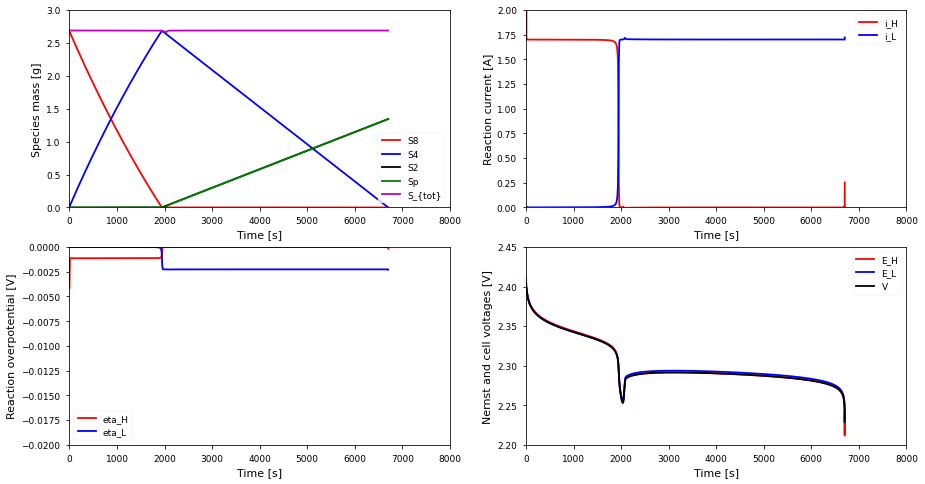

In [41]:
my_plot(sim)

Stepping the solution with fast mode also seems to give good performance. I think the solver struggles at the start too (could be related to initial conditions). You can see eta_H and i_H have a big jump at the start 

In [33]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="fast", extra_options_setup={"max_step_size": 0.1},
    ),
)

# step up to tf in steps of ts
tf = 7000
ts = 1000
t = 0
max_count = 10
count = 0
# take a small initial 60s step 
sim.step(60)
t = sim.solution.t[-1]
while t < tf:
    try:
        sim.step(ts,npts=int(ts/10))
    except (RuntimeError,pybamm.SolverError):
        count = count + 1
        ts = ts / 2 
    t = sim.solution.t[-1]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 6683.26 and h

IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  498.398 ms
Final time:  6685.0 s
Termination reason:  final time


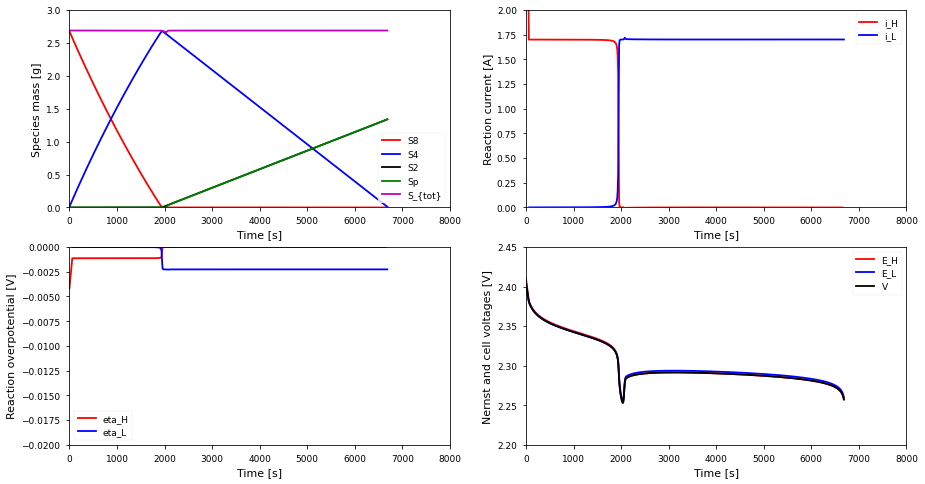

In [36]:
my_plot(sim)

This should be the same as using "safe mode" with `dt_max=ts` except you take a smaller initial step.

In [42]:
# Set up and solve simulation
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, rtol=1e-3, mode="safe", dt_max=1000, extra_options_setup={"max_step_size": 0.1},
    ),
)
sim.step(60)
sim.step(7000,npts=700)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [43]:
print("Solution time: ", sim.solution.solve_time)
print("Final time: ", sim.solution["Time [s]"].data[-1], "s")
print("Termination reason: ", sim.solution.termination)

Solution time:  636.376 ms
Final time:  6703.023254585844 s
Termination reason:  event: Zero theoretical capacity


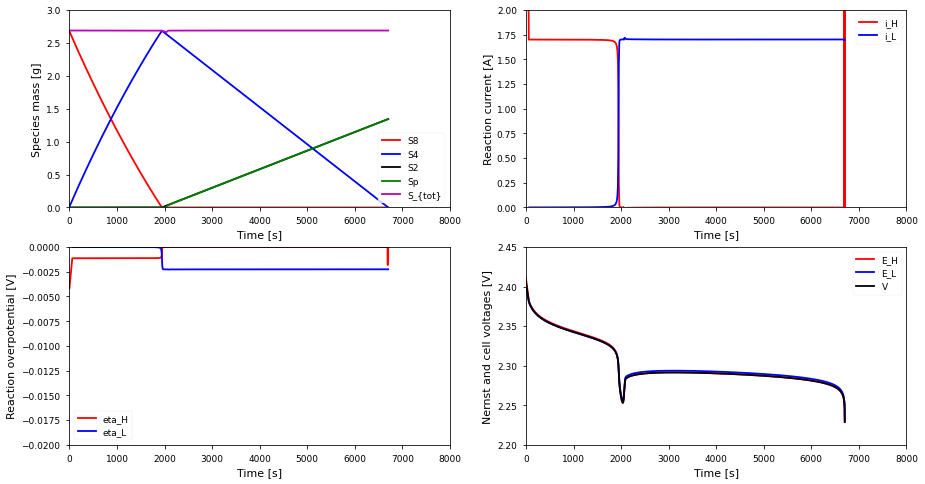

In [44]:
my_plot(sim)

This took a little longer but also went a little further. Try to resolve the big drop in voltage at the end is probably hard work and accounts for the extra solve time.

## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()